# Floating-point arithmetic

Arbitrary real numbers on computers are typically approximated by a set $\mathbb{F}$ of [floating-point numbers](https://en.wikipedia.org/wiki/Floating_point).  Basically, you should think of these as numbers in "scientific notation:"
$$
\pm\underbrace{d_0.d_1 d_2 d_3 ... d_{p-1}}_\textrm{significand} \times \beta^e, \;\; 0 \le d_k < \beta
$$
where the $d_k$ are digits of the **significand** in some base $\beta$ (typically $\beta=2$), the number of digits $p$ is the **precision**, and $e$ is the **exponent**.  That is, the computer actually stores a tuple (*sign*,*significand*,*exponent*), representing *a fixed number of significant digits over a wide range of magnitudes*.

Our goal is to eventually understand the set $\mathbb{F}$, how *rounding* occurs when you operate on floating-point values, how rounding errors *accumulate*, and how you analyze the accuracy of numerical algorithms.  In this notebook, however, we will just perform a few informal experiments in [Julia](http://julialang.org/) to get a feel for things.

## Entering and working with floating-point values

In [1]:
1.5e7 # a floating-point value 1.5 × 10⁷

1.5e7

In [2]:
x = 1/49 # division of two integers produces a floating-point value

0.02040816326530612

Since $1/49 \notin \mathbb{F}$, however, $x$ is actually a *rounded* version of $1/49$, and multiplying it by $49$ will yield something that is close to but *not quite equal to 1*.

In [3]:
x * 49

0.9999999999999999

In [4]:
1 - x * 49

1.1102230246251565e-16

This is about $10^{-16}$ because the default floating-point precision in Julia is **double precision**, with $p=53$ bits of significand ($\beta=2$).   Double precision, called the `Float64` type in Julia (64 bits overall), is used because it is **fast**: double-precision floating-point arithmetic is implemented by dedicated circuits in your CPU.

The precision can also be described by $\epsilon = 2^{p-1}$, which bounds the *relative error* between any element of $\mathbb{R}$ and the closest element of $\mathbb{F}$.  It is returned by `eps()` in Julia:

In [5]:
2.0^-52, eps(), eps(1.0), eps(Float64) # these are all the same thing

(2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16)

In fact, there is typically a small rounding error as soon as you enter a floating-point value, because most decimal fractions are not in $\mathbb{F}$.   This can be seen by either:
* converting to a higher precision with `big(x)` (converts to `BigFloat` [arbitrary-precision](https://en.wikipedia.org/wiki/Arbitrary-precision_arithmetic) value, by default with $p=256 bits$ or about 80 decimal digits)
* comparing to an exact rational — in Julia, `p // q` produces a `Rational` type, which is stored as a pair of integers

In [6]:
# 1.5 is exactly represented in binary floating point:
big(1.5), 1.5 == 3//2

(1.5, true)

In [7]:
# 0.1 is *not* exactly represented
big(0.1), 0.1 == 1//10

(0.1000000000000000055511151231257827021181583404541015625, false)

## Accumulation of roundoff errors

A common mistake is to confuse **precision** with **accuracy**.   A value can be *more accurate* or *less accurate* than the precision (number of digits) with which it is represented.

For example, the value `3.0` in floating point (represented exactly in $\mathbb{F}$) is an exact value for the number of sides of a triangle, but a rather inaccurate approximation for π.

Most commonly, floating-point values are *less accurate* than the precision allows, because **roundoff errors accumulate** over the course of a long computation.   To see this, let us consider the function `y = cumsum(x)` in Julia, which computes
$$
y_k = \sum_{i=1}^k x_i
$$
We will try this for random $x_i \in [0,1)$, and compare to the "exact" value of the sum.  Although `cumsum` is built-in to Julia, we will write our own version so that we can see exactly what it is doing:

In [8]:
function my_cumsum(x)
    y = similar(x) # allocate an array of the same type and size as x
    y[1] = x[1]
    for i = 2:length(x)
        y[i] = y[i-1] + x[i]
    end
    return y
end

my_cumsum (generic function with 1 method)

Now, how to we get the "exact" sum for comparing the error?   The trick is that we will do the sum in **two precisions**: *double precision* and *single precision* (Julia `Float32` = 32 bits), where single precision is about 7-8 decimal digits ($p=24$ bits).  Since double precision has about twice as many digits as single precision, we can treat the double precision result as "exact" compared to the single-precision result in order to compute the accuracy in the latter.

In [9]:
eps(Float32), eps(Float64)

(1.1920929f-7, 2.220446049250313e-16)

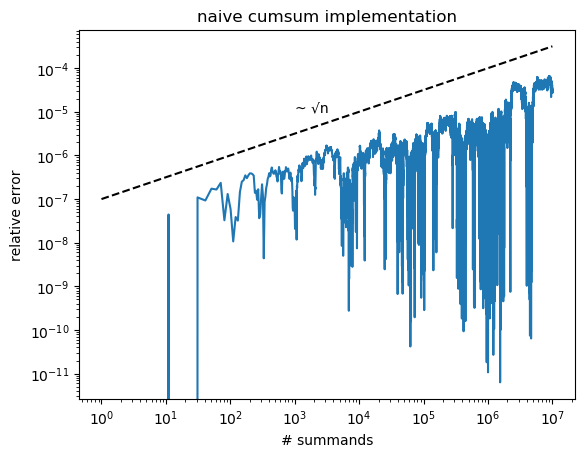

  0.134295 seconds (18.19 k allocations: 39.103 MiB, 48.52% gc time)


PyObject Text(0.5, 1.0, 'naive cumsum implementation')

In [10]:
x = rand(Float32, 10^7) # 10^7 single-precision values uniform in [0,1)
@time y = my_cumsum(x)
yexact = my_cumsum(Float64.(x)) # same thing in double precision
err = abs.(y .- yexact) ./ abs.(yexact) # relative error in y

using PyPlot
n = 1:10:length(err) # downsample by 10 for plotting speed
loglog(n, err[n])
ylabel("relative error")
xlabel("# summands")
# plot a √n line for comparison
loglog([1,length(err)], sqrt.([1,length(err)]) * 1e-7, "k--")
gca()[:annotate]("~ √n", xy=(1e3,1e-5), xytext=(1e3,1e-5))
title("naive cumsum implementation")

Note that the error starts around $10^{-7}$ (about `eps(Float32)`), but gets worse than the precision as the number of summands grows.

As you can see, the relative error has an upper bound that scales roughly proportional $\sqrt{n}$ where $n$ is the number of summands.   Intuitively, there is a little roundoff error from each addition, but the roundoff error is somewhat random in $[-\epsilon,+\epsilon]$ and hence the roundoff errors grow as a [random-walk](https://en.wikipedia.org/wiki/Random_walk) process $\sim \sqrt{n}$.

However, **one can do better than this**.  If you use the built-in `cumsum` function in Julia 0.3.6 or later, you will see *very different* error growth: the mean errors actually grow as roughly $\sqrt{\log n}$.  Not only that, but the output of the `@time` macro indicates that the built-in `cumsum` (which is also written in Julia) is actually a bit *faster* than our `my_cumsum`.

We will have to investigate summation in more detail to understand how this can be possible.

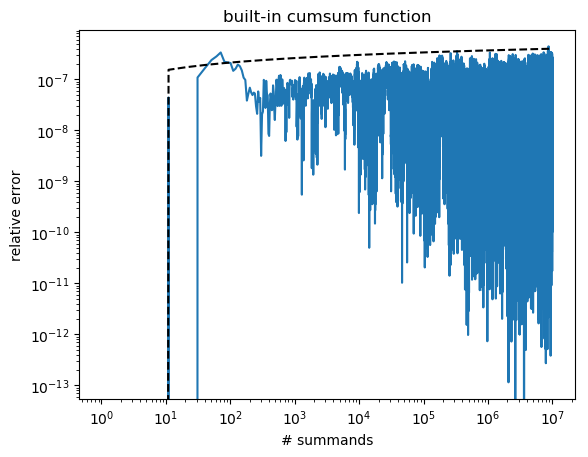

  0.108475 seconds (228.33 k allocations: 49.425 MiB, 7.36% gc time)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x150fdf080>

In [11]:
VERSION < v"0.3.6" && warn("cumsum is less accurate for Julia < 0.3.6")
@time y2 = cumsum(x)
err2 = abs.(y2 .- yexact) ./ abs.(yexact)
loglog(n, err2[n])
ylabel("relative error")
xlabel("# summands")
title("built-in cumsum function")
loglog(n, sqrt.(log.(n)) * 1e-7, "k--")

## Overflow, Underflow, Inf, and NaN

Because a floating-point value uses a finite number of bits to store the exponent `e`, there is a maximum and minimum magnitude for floating-point values.   If you go over the maximum, you **overflow** to a special `Inf` value (or `-Inf` for large negative values), representing $\infty$.   If you go under the minimum, you **underflow** to $\pm 0.0$, where $-0$ is used to represent e.g. a value that underflowed from the negative side.

In [12]:
1e300 # okay: 10³⁰⁰ is in the representable range

1.0e300

In [13]:
(1e300)^2 # overflows

Inf

We can get the maximum representable magnitude via `floatmax`

In [15]:
floatmax(Float64), floatmax(Float32)

(1.7976931348623157e308, 3.4028235f38)

In [16]:
1e-300 # okay

1.0e-300

In [17]:
(1e-300)^2 # underflows to +0

0.0

You can use `floatmin` in Julia to find the minimum-magnitude floating-point value:

In [18]:
floatmin(Float64), floatmin(Float32)

(2.2250738585072014e-308, 1.1754944f-38)

In [19]:
-1e-300 * 1e-300 # underflows to -0

-0.0

While -0 is printed differently from +0, they still compare equal.  However, you will notice the difference if you do something that depends on the sign:

In [20]:
+0.0 == -0.0

true

In [21]:
1 / +0.0, 1 / -0.0

(Inf, -Inf)

In [22]:
signbit(+0.0), signbit(-0.0)

(false, true)

Since 1/-Inf is -0.0, this has the nice property that:

In [23]:
1 / (1 / -Inf)

-Inf

A special value `NaN` ("not a number") is used to represent the result of floating-point operations that can't be defined in a sensible way (e.g. [indeterminate forms](https://en.wikipedia.org/wiki/Indeterminate_form)):

In [24]:
0 * Inf, Inf / Inf, 0 / 0

(NaN, NaN, NaN)

In some other languages, `NaN` is also used to signal that a function cannot be evaluated.  For example, in C, `sqrt(-1.0)` returns `NaN`.  However, Julia typically [throws](http://docs.julialang.org/en/latest/manual/control-flow/#man-exception-handling) an [exception](https://en.wikipedia.org/wiki/Exception_handling) in these cases:

In [25]:
sqrt(-1.0)

DomainError: DomainError with -1.0:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).

If you want a complex *output* from the `sqrt` function, you need to give it a complex *input*:

In [26]:
sqrt(-1.0 + 0im)

0.0 + 1.0im

The reason for this is a technical criterion called [type stability](http://docs.julialang.org/en/latest/manual/performance-tips/#write-type-stable-functions) that is essential for Julia code to be compiled to fast machine instructions.  (The lack of type stability in many standard-library functions is a key contributor to the difficulty of retrofitting fast compilers to languages like Python and Matlab.)